In [9]:
import os
from dotenv import load_dotenv 
load_dotenv()

from langchain_groq import ChatGroq
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
llm = ChatGroq(model='llama-3.1-8b-instant')


In [10]:
# Some custom function
def addition(a:int, b:int) -> int:
    """ Addition of a and b
    Args:
        a:first int
        b:second int
    """
    return a+b
    
def multiply(a:int, b:int) -> int:
    """ Multiplication of a and b
    Args:
        a:first int
        b:second int
    """
    return a*b

def divide(a:int, b:int) -> float:
    """ Divide a from b
    Args:
        a:first int
        b:second int
    """
    return a/b

tools = [addition,multiply,divide]

In [11]:
tools

[<function __main__.addition(a: int, b: int) -> int>,
 <function __main__.multiply(a: int, b: int) -> int>,
 <function __main__.divide(a: int, b: int) -> float>]

In [12]:
# Intigarte the tools with  llm
llm_with_tools = llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002826E133EC0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002826D8AB5C0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'addition', 'description': 'Addition of a and b\nArgs:\n    a:first int\n    b:second int', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiplication of a and b\nArgs:\n    a:first int\n    b:second int', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'divide', 'description': 'Divide a from b\nArgs:\n    a:first int\n    b:second int', 'parameters': {'propertie

In [13]:
from IPython.display import display,Image
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState,START,StateGraph
from langgraph.prebuilt import tools_condition,ToolNode
from langchain_core.messages import AIMessage,HumanMessage,SystemMessage

## System messages
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arthmetic operation on a section")

## Node definition
def assistant(state:MessagesState):
    return {'messages': [llm_with_tools.invoke([sys_msg] + state['messages'])]}

#Graph
builder = StateGraph(MessagesState)

#adding the node
builder.add_node('assistant',assistant)
builder.add_node('tools',ToolNode(tools))

#Define the edges
builder.add_edge(START,'assistant')
builder.add_conditional_edges('assistant',tools_condition)

builder.add_edge("tools","assistant")

memory = MemorySaver()

graph = builder.compile(interrupt_before=['assistant'],checkpointer=memory)




In [14]:
#Show
display(Image(graph.get_graph().draw_mermaid_png()))

ValueError: Failed to reach https://mermaid.ink/ API while trying to render your graph. Status code: 502.

To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

In [15]:
thread = {'configurable': {"thread_id":"123"}}
initial_input = {'messages':HumanMessage(content="multiply 2 and 3")}

In [16]:
for event in graph.stream(initial_input,thread,stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

multiply 2 and 3


In [17]:
state=graph.get_state(thread)
state.next

('assistant',)

In [18]:
for event in graph.stream(None,thread,stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (vhymk29x1)
 Call ID: vhymk29x1
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


In [19]:
for event in graph.stream(None,thread,stream_mode='values'):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of the multiplication operation is 6.


### Edit Human Feedback

In [20]:
thread = {'configurable': {"thread_id":"2"}}
initial_input = {'messages':HumanMessage(content="multiply 2 and 3")}

In [21]:
for event in graph.stream(initial_input,thread,stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

multiply 2 and 3


In [22]:
state=graph.get_state(thread)
state.next

('assistant',)

In [23]:
graph.update_state(thread,{'messages':[HumanMessage(content='No, please multiply 15 and 6')]})

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f09ba1b-b274-698d-8001-9332fc21ce62'}}

In [24]:
new_state=graph.get_state(thread).values

for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

multiply 2 and 3
================================ Human Message =================================

No, please multiply 15 and 6


In [25]:
for event in graph.stream(None,thread,stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, please multiply 15 and 6
================================== Ai Message ==================================

<multiply>{"a": 15, "b": 6}</multiply>


In [26]:
for event in graph.stream(None,thread,stream_mode='values'):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================

<multiply>{"a": 15, "b": 6}</multiply>


### Workflow will Wait for User Input

In [ ]:
from langchain_core.messages import SystemMessage
#System message
sys_msg  = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

#Human feedback node
def human_feedback(state:MessagesState):
    pass

## Assistant NOde
def assistant(state:MessagesState):
    return {'message':[llm_with_tools.invoke([sys_msg] + state['messages'])]}

#Graph
builder = StateGraph(state_schema=MessagesState)

builder.add_node("assistant",assistant)
builder.add_node('tools',ToolNode(tools))
builder.add_node('human_feedback',human_feedback)

# Define the edges
builder.add_edge(START,"human_feedback")
builder.add_edge('human_feedback','assistant')
builder.add_conditional_edges("assistant",tools_condition)

builder.add_edge("tools","human_feedback")

memory = MemorySaver()



graph = builder.compile(checkpointer=memory,interrupt_before=['human_feedback'])

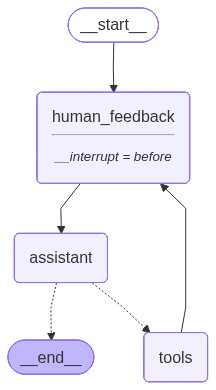

In [28]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [33]:
#Input 
initial_input = {'messages':'Multiply 2 and 3'}

thread = {"configurable": {"thread_id":"6"}}

for event in graph.stream(config=thread,stream_mode='values',input=initial_input):
    event['messages'][-1].pretty_print()

## Get the user input
user_input = input("Tell me how you want to update the state:")
graph.update_state(thread,{"messages":user_input},as_node="human_feedback")

#Continue the graph execution
for event in graph.stream(config=thread,input=None,stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

please multiply 5 and 9


In [34]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

please multiply 5 and 9
